# Learning Outcomes
- Image histogram
- Histogram equalization / CLAHE:
    * purpose: contrast enhancement (same effect as simple scalar multiplication)
- Thresholding (end results: binary mask with 255 as foreground)
- Morphological operations (manipulate the mask)
    - Erosion
    - Dilation
    - Opening
    - Closing
- Color spaces: RGB, HSV and L\*a\*b
- Color based segmentation (HSV). Hue represents color, one channel encode color information.

# Setup

In [3]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

In [4]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [5]:
# 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

81.6 µs ± 5.73 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.76 ms ± 532 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


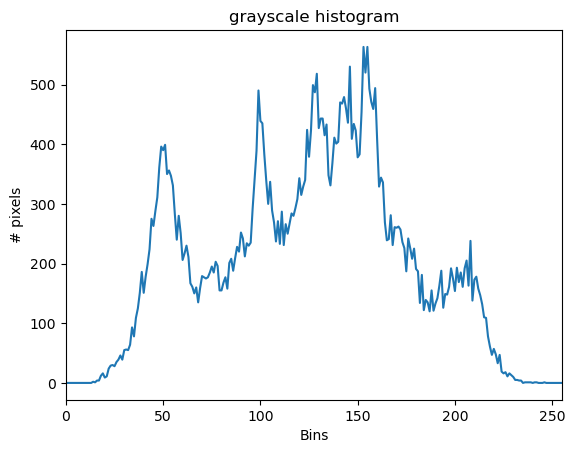

In [6]:
# construct histogram
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

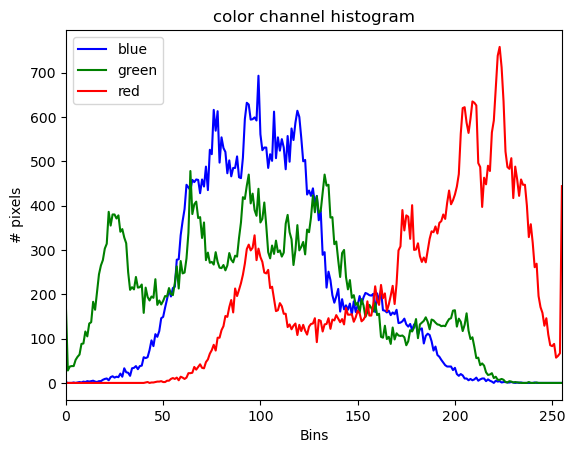

In [7]:
# compute histogram for all the channels
channels = cv.split(img)
colors = ("blue", "green", "red")

plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label=color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

## Histogram equalization

In [8]:
img = cv.imread("images/low_contrast_img.jfif", 0)  # 0 means change the image into grayscale
show_img("low_contrast", img)

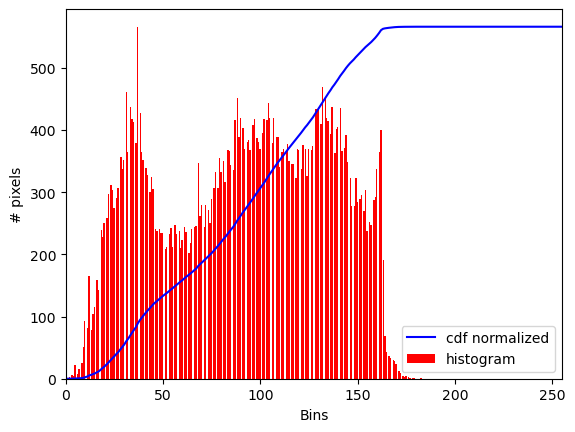

In [9]:
# histogram
hist = cv.calcHist([img], [0], None, [256], [0, 256])

#compute cdf
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.show()

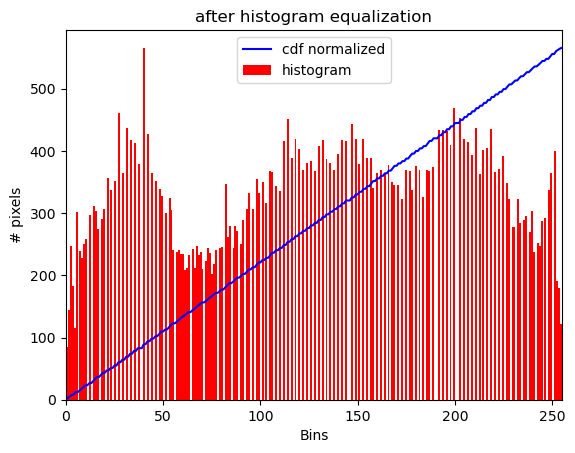

In [10]:
# histogram equalization
eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_normalized, color="b")
plt.hist(eq.flatten(), 256, color="r")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0, 255])
plt.legend(("cdf normalized", "histogram"))
plt.title("after histogram equalization")
plt.show()

In [11]:
cv.imshow("original", img)
show_img("equalization", eq)

In [12]:
#
img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("orginial", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

In [13]:
#
img = cv.imread("images/winter_low_contrast.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(8, 8))   # clipLimit - for better enhancement ( 2 to 3 is the good starting place)
dst = clahe.apply(img)

cv.imshow("orginial", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

## Exercise 1

In [14]:
img = cv.imread("images/winter.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=2, tileGridSize=(6, 6))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("clahe", dst)

In [15]:
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [16]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype=np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)    # most important
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Comparison on the thresholding methods

In [17]:
img = cv.imread("images/noisy.jfif", 0)

# First
show_img("noisy image", img)

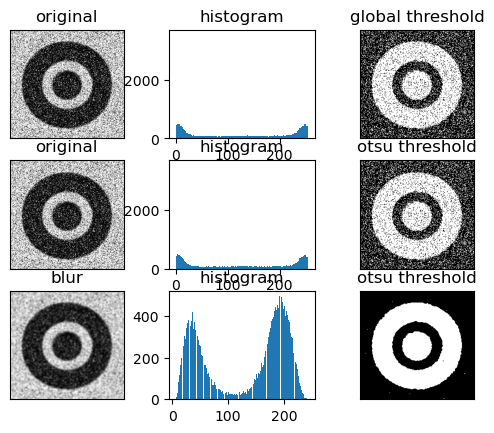

In [18]:
# apply 3 methods
#1: global threshold
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2: OTSU threshold
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3: Gaussian blur + otsu threshold
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1, 
        img, 0, th2, 
        blur, 0, th3]

titles = ("original", "histogram", "global threshold", 
          "original", "histogram", "otsu threshold", 
          "blur", "histogram", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256)
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
                
plt.show()

## Morphological operations
- erosion
- dilation
- opening (erosion + dilation)
- closing (dilation + erosion)

In [19]:
# define structuring element
kernel = np.ones((3, 3), dtype=np.uint8)

# erosion
dst = cv.erode(th3, kernel, iterations=1)

# show
img_combined = np.hstack((th3, dst))

show_img("erosion", img_combined)

In [20]:
# define structuring element
kernel = np.ones((3, 3), dtype=np.uint8)

# dilation
dst = cv.dilate(th3, kernel, iterations=1)

# show
img_combined = np.hstack((th3, dst))

show_img("dilation", img_combined)

In [21]:
# trackbar function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        
    # define the kernel
    kernel = np.ones((size, size), dtype=np.uint8)
    # erosion
    erosion = cv.erode(th3, kernel, iterations=iteration)
    
    cv.imshow(wn, erosion)
    k = cv.waitKey(1) & 0xFF
    if k == 27:   # press ESC key
        break
        

cv.destroyAllWindows()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2561: error: (-27:Null pointer) NULL window: 'window' in function 'cvGetTrackbarPos'


In [22]:
# CLOSING
res = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations=2)

img_combined = np.hstack((th3, res))

show_img("closing", img_combined)

## Color spaces
- RGB (the most prevalent color space. Any picture is stored under this format, but the downside of this color space is that there is no clear way to separate chroma (color and its saturation)). Not suitable for color based segmentation.
- HSV (Hue, Saturation, Value)
    - Hue -> color (make use of hue to segment color)
    - Saturation -> purity of color
    - Value -> brightness / luminance
- LAB
    - perceptual uniformity (the Euclidean distance in the color space corresponds to perceptual uniformity).

In [23]:
# Image sharpening with LAB
#1: split image into l, a, b
#2: sharpen the l channel
#3: merge the color channels

img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
l, a, b = cv.split(img_lab)

# define the sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
l_sharpened = cv.filter2D(1, -1, kernel)

# merge
img_lab_merge = cv.merge((l_sharpened, a, b))
dst = cv.cvtColor(img_lab_merge, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", dst)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\merge.dispatch.cpp:129: error: (-215:Assertion failed) mv[i].size == mv[0].size && mv[i].depth() == depth in function 'cv::merge'


## demo on color based segmentation

In [24]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

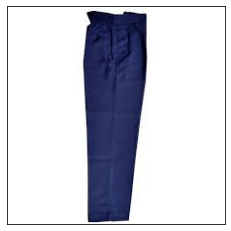

In [31]:
plt_img(img)
plt.show()

## Show the pixels in rgb color space

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

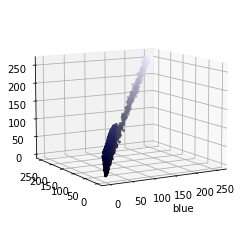

In [33]:
# split the color channels
r, g, b = cv.split(img)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection="3d")

# encode the color information
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# ravel() means flatten()
axes.scatter(r.ravel(), g.ravel(), b.ravel(), facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=240)
axes.set_xlabel("red")
axes.set_xlabel("green")
axes.set_xlabel("blue")
plt.show()

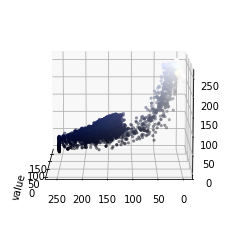

In [34]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1, projection="3d")

axes.scatter(h.ravel(), s.ravel(), v.ravel(), facecolors=pixel_colors, marker=".")
axes.view_init(elev=10, azim=180)
axes.set_xlabel("hue")
axes.set_xlabel("saturation")
axes.set_xlabel("value")
plt.show()

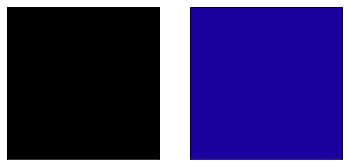

In [35]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype=np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype=np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

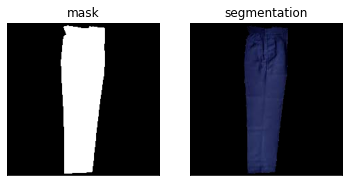

In [36]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)

plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation")
plt.show()

## Exercise

In [41]:
def color_seg(img, low_color, high_color, smooth=True):
    """Arguments
    img: source image (RGB)
    color-low: low HSV value
    color-high: high HSV value
    smooth: boolean (Gaussian blurring)
    """
    img_ori = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask = cv.inRange(img_hsv, low_color, high_color)
    # morphological operations
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    return cv.bitwise_and(img_ori, img_ori, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
    
res = [color_seg(img, blue_low, blue_high) for img in imgs]

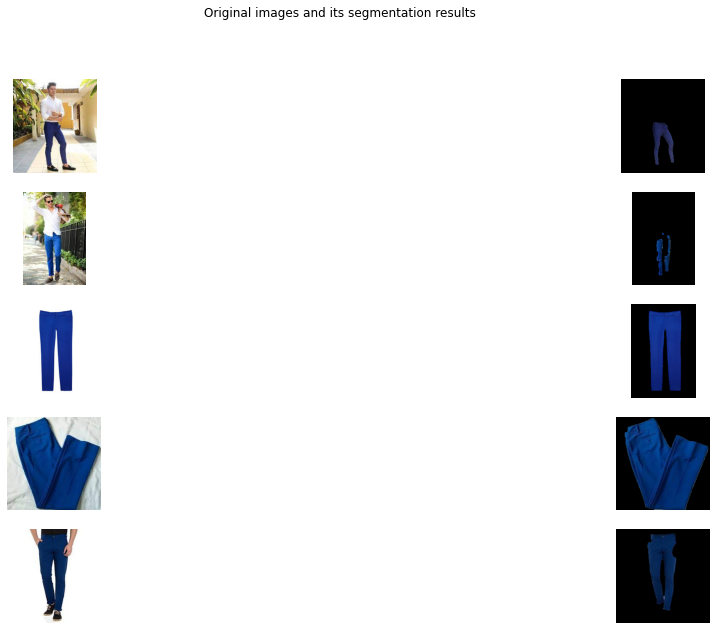

In [46]:
fig, ax = plt.subplots(5, 2, figsize=(20, 10))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")


fig.suptitle("Original images and its segmentation results")
plt.show()

## Weekly Activity

### Question 1

In [27]:
img = cv.imread("images/boat.jpg", 0)

# Apply Otsu thresholding
ret, th = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# Find contours in the thresholded image
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_bbox = cv.cvtColor(img, cv.COLOR_GRAY2BGR)

# Loop over the contours and draw bounding boxes
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    if w > 50 and h > 50:
        cv.rectangle(img_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
cv.imshow("Segmented boat and people", img_bbox)
cv.waitKey(0)
cv.destroyAllWindows()

### Question 2

In [29]:
import cv2 as cv
import numpy as np

def trackbar(size):
    img = cv.imread("images/leaf.jfif", cv.IMREAD_GRAYSCALE)

    # Threshold the image to segment the leaf from the background
    ret, th = cv.threshold(img, 128, 255, cv.THRESH_BINARY)

    # Define the structuring element
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (size, size))

    # Perform morphological operations
    erosion = cv.erode(th, kernel, iterations=1)
    dilation = cv.dilate(th, kernel, iterations=1)
    opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel)

    # Concatenate the images horizontally for visualization
    result = np.hstack((th, erosion, dilation, opening, closing))

    # Display the result
    cv.imshow('Morphological Transformations', result)
    cv.resizeWindow('Morphological Transformations', 5 * result.shape[1], result.shape[0])
    cv.waitKey(1)

# Create a window to display the results
cv.namedWindow('Morphological Transformations', cv.WINDOW_NORMAL)

# Create a trackbar to control the size of the structuring element
cv.createTrackbar('Size', 'Morphological Transformations', 1, 30, trackbar)

# Initialize the GUI with a default size of 1
trackbar(1)

cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.8.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\filterengine.hpp:367: error: (-215:Assertion failed) anchor.inside(Rect(0, 0, ksize.width, ksize.height)) in function 'cv::normalizeAnchor'


### Question 3

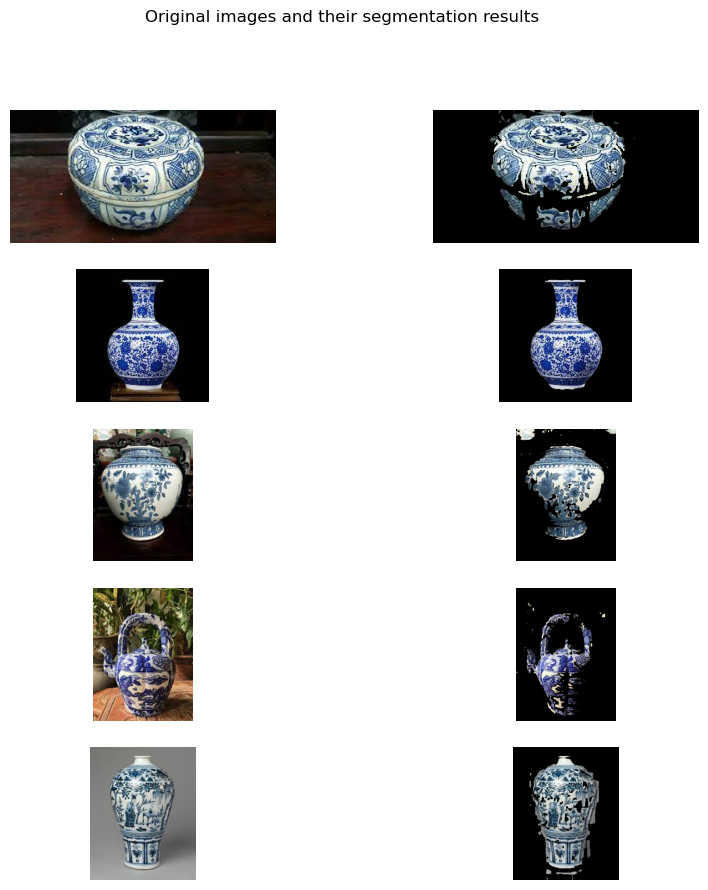

In [33]:
import cv2 as cv
import matplotlib.pyplot as plt

def color_seg(img, low_blue, high_blue, low_white, high_white, smooth=True):
    """Arguments
    img: source image (RGB)
    low_blue: low HSV value for blue color
    high_blue: high HSV value for blue color
    low_white: low HSV value for white color
    high_white: high HSV value for white color
    smooth: boolean (Gaussian blurring)
    """
    img_ori = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    mask_blue = cv.inRange(img_hsv, low_blue, high_blue)
    mask_white = cv.inRange(img_hsv, low_white, high_white)
    
    img_segmented = cv.bitwise_or(mask_blue, mask_white)
    return cv.bitwise_and(img_ori, img_ori, mask=img_segmented)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
blue_low = (90, 0, 50)
blue_high = (130, 255, 255)

white_low = (0, 0, 200)
white_high = (180, 60, 255)
    
res = [color_seg(img, blue_low, blue_high, white_low, white_high) for img in imgs]
fig, ax = plt.subplots(5, 2, figsize=(10, 10))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")

fig.suptitle("Original images and their segmentation results")
plt.show()
